In [3]:
#pip install mwclient

In [4]:
#pip install --upgrade ipykernel --user

<blockquote>
    To access data from wikipedia, use the library mwclient - Media Wiki Client.
</blockquote>

In [5]:
import mwclient
import time
import numpy as np
import pandas as pd
from datetime import datetime

<blockquote>
    Create a <i>mwclient.Site</i> class by specifying the wikipedia url we need to access (English)
</blockquote>

In [6]:
site = mwclient.Site("en.wikipedia.org")

<blockquote>
    Specify the pages in the site that we need to access
</blockquote>

In [7]:
page = site.pages["Bitcoin"]

<blockquote>
    mwclient.Site.pages.revisions() returns an iterable of all the revisions performed on a specific page in wikipedia. The individual elements take the form of a dictionary with <i>timestamp</i> and <i>comments</i> as two of the many keys.
</blockquote>

In [20]:
rev = list(page.revisions(excludeuser='Staxringold'))

In [21]:
len(rev)

16984

In [22]:
rev[0]

OrderedDict([('revid', 1109601510),
             ('parentid', 1109601379),
             ('minor', ''),
             ('user', 'Eden5'),
             ('timestamp',
              time.struct_time(tm_year=2022, tm_mon=9, tm_mday=10, tm_hour=20, tm_min=45, tm_sec=38, tm_wday=5, tm_yday=253, tm_isdst=-1)),
             ('comment',
              'Undid revision 1109601379 by [[Special:Contributions/Staxringold|Staxringold]] ([[User talk:Staxringold|talk]])')])

<blockquote>
    Sorting the list of revisions on the timestamp - ascending order.
</blockquote>

In [23]:
rev = sorted(rev, key=lambda revs: revs["timestamp"])

In [24]:
rev[0]

OrderedDict([('revid', 275832581),
             ('parentid', 0),
             ('user', 'Pratyeka'),
             ('timestamp',
              time.struct_time(tm_year=2009, tm_mon=3, tm_mday=8, tm_hour=16, tm_min=41, tm_sec=7, tm_wday=6, tm_yday=67, tm_isdst=-1)),
             ('comment', 'creation (stub)')])

<blockquote>
    Installing the <i>Transformers</i> module to perform sentiment analysis.
</blockquote>

In [15]:
#pip install transformers

In [16]:
from transformers import pipeline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters


<blockquote>
    Creation of a pipeline object for sentiment analysis. This model takes a list of text as argument and returns a dictionary of <i>score</i> and <i>label</i> indicating the sentiment of the text.
</blockquote>

In [17]:
sentiment_pipleline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


<blockquote>
    Defining a function to get the sentiment of a text as a single value representing both score & label. Negative sentiments will have a negative numeric value.
</blockquote>

In [18]:
def find_sentiment(text):
    sent = sentiment_pipleline([text[:250]])[0]
    score = sent["score"]
    if sent["label"] == 'NEGATIVE':
        score *= -1
    return score

In [19]:
find_sentiment("Yesterday was perfect.")

0.9998781681060791

<blockquote>
    Creating a dictionary called <i>edits</i> whose key is dates when revisions were made and value is a dictionary holding two properties - number of revisions on the day and the list of individual sentiments of comments. 
</blockquote>

In [25]:
edits={}
for record in rev:
    date = time.strftime('%Y-%m-%d', record["timestamp"])
    if date not in edits:
        edits[date] = dict(sentiments=[find_sentiment(record['comment'])], sentiment_count=1)
    else:
        edits[date]['sentiments'].append(find_sentiment(record['comment']))
        edits[date]['sentiment_count'] += 1

<blockquote>
    Updating the <i>edits</i> dictionary to add <i>mean sentiment</i> and <i>percentage of negative sentiments</i>.
</blockquote>

In [26]:
for record in edits:
    if len(edits[record]['sentiments']) > 0:
        edits[record]['mean_sentiment'] = np.mean(edits[record]['sentiments'])
        edits[record]['neg_percent'] = len([s for s in edits[record]['sentiments'] if s < 0])/len(edits[record]['sentiments'])
    else:
        edits[record]['mean_sentiment'] = 0
        edits[record]['neg_percent'] = 0

In [34]:
edits[list(edits.keys())[0]]

{'sentiments': [-0.9905920624732971,
  0.7481211423873901,
  -0.9907428622245789,
  -0.9688861966133118],
 'sentiment_count': 4,
 'mean_sentiment': -0.5505249947309494,
 'neg_percent': 0.75}

<blockquote>
    Deleting the key-value pairs of key <i>sentiments</i> to help in converting the <i>edits</i> dictionary to a dataframe.
</blockquote>

In [35]:
for key in edits:
    del(edits[key]['sentiments'])

<blockquote>
    Creating the dataframe of revision history containing details of sentiments.
</blockquote>

In [109]:
first_record = True
for key in edits:
    if first_record:
        df = pd.DataFrame(edits[key], index=[key])
    else:
        df1 = pd.DataFrame(edits[key], index=[key])
        df = pd.concat([df, df1])
    first_record = False

In [110]:
df.head(10)

,sentiment_count,mean_sentiment,neg_percent
2009-03-08,4,-0.550525,0.75
2009-08-05,1,0.748121,0.00
2009-08-06,2,0.995746,0.00
2009-08-14,1,0.930021,0.00
2009-10-13,2,-0.227499,0.50
2009-11-18,1,0.883952,0.00
2009-12-08,1,-0.986927,1.00
2009-12-17,1,-0.997517,1.00
2010-02-23,1,-0.999495,1.00
2010-03-18,1,0.875878,0.00


<blockquote>
    Converting the datatype of the index to datetime.
</blockquote>

In [111]:
df.index = pd.to_datetime(df.index)

<blockquote>
    Addition of records to the dataframe for missing values of dates.
</blockquote>

In [112]:
dates = pd.date_range(start="2009-03-08", end=datetime.today())
df = df.reindex(dates, fill_value=0)

In [113]:
df

,sentiment_count,mean_sentiment,neg_percent
2009-03-08,4,-0.550525,0.75
2009-03-09,0,0.000000,0.00
2009-03-10,0,0.000000,0.00
2009-03-11,0,0.000000,0.00
2009-03-12,0,0.000000,0.00
...,...,...,...
2022-09-13,0,0.000000,0.00
2022-09-14,0,0.000000,0.00
2022-09-15,0,0.000000,0.00
2022-09-16,0,0.000000,0.00


<blockquote>
    Getting the rolling averages of numeric columns for 30 days.
</blockquote>

In [114]:
df_rolling = df.rolling(30).mean()

In [115]:
df_rolling.head(31)

,sentiment_count,mean_sentiment,neg_percent
2009-03-08,NaN,NaN,NaN
2009-03-09,NaN,NaN,NaN
2009-03-10,NaN,NaN,NaN
2009-03-11,NaN,NaN,NaN
2009-03-12,NaN,NaN,NaN
2009-03-13,NaN,NaN,NaN
2009-03-14,NaN,NaN,NaN
2009-03-15,NaN,NaN,NaN
2009-03-16,NaN,NaN,NaN
2009-03-17,NaN,NaN,NaN


<blockquote>
    Drop NaN values
</blockquote>

In [116]:
df_rolling = df_rolling.dropna()

In [117]:
df_rolling

,sentiment_count,mean_sentiment,neg_percent
2009-04-06,0.133333,-0.018351,0.025000
2009-04-07,0.000000,0.000000,0.000000
2009-04-08,0.000000,0.000000,0.000000
2009-04-09,0.000000,0.000000,0.000000
2009-04-10,0.000000,0.000000,0.000000
...,...,...,...
2022-09-13,0.500000,-0.114184,0.183333
2022-09-14,0.500000,-0.114184,0.183333
2022-09-15,0.500000,-0.114184,0.183333
2022-09-16,0.400000,-0.121123,0.172222


<blockquote>
    Writing the dataframe to a csv file.
</blockquote>

In [55]:
df_rolling.to_csv('C:\\Users\\mailn\\Downloads\\btc_wiki_edits.csv')

<blockquote>
    Additional code for generating charts.
</blockquote>

In [207]:
df_mod = df.copy()
year_series=pd.Series(df.index).apply(lambda i: i.year)
year_series.index=df.index
df_mod=pd.concat([df_mod, year_series], axis=1)
df_mod.rename(columns={0:'year'}, inplace=True)

In [208]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4942 entries, 2009-03-08 to 2022-09-17
Freq: D
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sentiment_count  4942 non-null   int64  
 1   mean_sentiment   4942 non-null   float64
 2   neg_percent      4942 non-null   float64
 3   year             4942 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 353.0 KB


In [209]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()

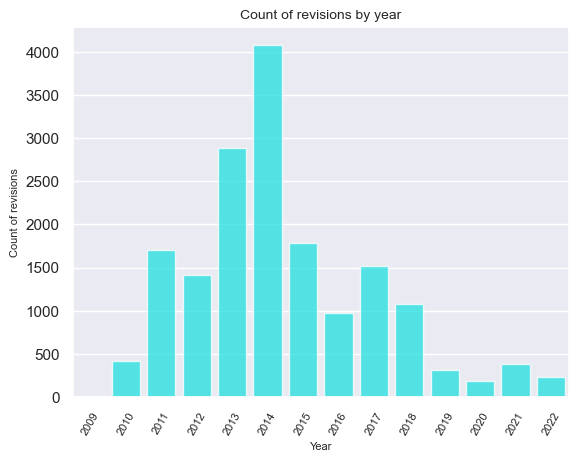

In [210]:
df_group=pd.DataFrame(df_mod.groupby('year')['sentiment_count'].sum())
sns.barplot(data=df_group, x=df_group.index, y='sentiment_count', alpha=0.75, color='cyan')
plt.ylabel('Count of revisions', font='Arial', size=8)
plt.xlabel('Year', font='Arial', size=8)
plt.title('Count of revisions by year', font='Arial', size=10)
plt.xticks(rotation=60, font='Arial', size=8)
plt.show()